In [1]:
"""
The script demonstrates a simple example of using ART with PyTorch. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from art.attacks.evasion import FeatureAdversariesPyTorch
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist


# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

# Step 2: Create the model

model = nn.Sequential(
    nn.Conv2d(1, 4, 5), nn.ReLU(), nn.MaxPool2d(2, 2), 
    nn.Conv2d(4, 10, 5), nn.ReLU(), nn.MaxPool2d(2, 2),
    nn.Flatten(), 
    nn.Linear(4*4*10, 100),    
    nn.Linear(100, 10)
)
# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

# Step 6: Generate adversarial test examples
#ttack = FeatureAdversariesPyTorch(classifier, layer=7,delta=10/255, step_size=0.1, max_iter=50)
from torch.optim import LBFGS, SGD, Adam


attack = FeatureAdversariesPyTorch(classifier, layer=7, delta=61/255, optimizer=Adam,
                                   optimizer_kwargs={"lr": 0.01},
                                   lambda_=1.0, max_iter=100, random_start=True)
# # LBFGS variant
# attack = FeatureAdversariesPyTorch(classifier, layer=7, delta=35.5/255, optimizer=LBFGS,
#                                    optimizer_kwargs={"lr": 1, "max_iter": 20},
#                                    lambda_=1.0, max_iter=50)

#PGD variant
# attack = FeatureAdversariesPyTorch(classifier, layer=7, delta=35/255, optimizer=None,
#                                    lambda_=0.0, step_size=1/255, max_iter=100)

valid = np.argmax(y_test, axis=1)[:100] != np.argmax(y_test, axis=1)[100:200]
source = x_test[:100][valid][:32]
guide = x_test[100:200][valid][:32]

#x_test_adv = attack._generate_batch(torch.tensor(source), torch.tensor(guide))
#x_test_adv = x_test_adv.detach().cpu().numpy()
x_test_adv = attack.generate(source, guide)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:100][valid][:32], axis=1)) / len(y_test[:100][valid][:32])
print("Accuracy on adversarial test batch: {}%".format(accuracy * 100))


Accuracy on benign test examples: 96.76%


Feature Adversaries PyTorch:   0%|          | 0/100 [00:00<?, ?it/s]

Iter 0, loss 225.8173370361328, constraint 0.24919502437114716
Iter 1, loss 200.65733337402344, constraint 0.24922925233840942
Iter 2, loss 181.11036682128906, constraint 0.24924923479557037
Iter 3, loss 165.85818481445312, constraint 0.24927107989788055
Iter 4, loss 153.41233825683594, constraint 0.2492923140525818
Iter 5, loss 143.2724609375, constraint 0.24933242797851562
Iter 6, loss 134.2829132080078, constraint 0.2493947148323059
Iter 7, loss 126.52005004882812, constraint 0.24944981932640076
Iter 8, loss 119.69583129882812, constraint 0.24952928721904755
Iter 9, loss 113.74622344970703, constraint 0.2495976984500885
Iter 10, loss 108.68122100830078, constraint 0.24966353178024292
Iter 11, loss 104.14208984375, constraint 0.24975281953811646
Iter 12, loss 100.01905059814453, constraint 0.24982714653015137
Iter 13, loss 96.265869140625, constraint 0.2499459683895111
Iter 14, loss 92.74263000488281, constraint 0.25002023577690125
Iter 15, loss 89.44548034667969, constraint 0.250091

In [2]:
import matplotlib.pyplot as plt

# orig labels
#np.argmax(y_test[range(0,11,2)], axis=1)

# guide labels
#np.argmax(y_test[range(100,111,2)], axis=1)

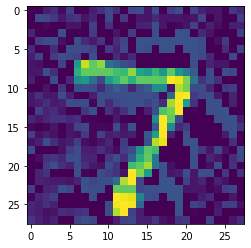

In [3]:
# orig 7, guide 6
plt.imshow(x_test_adv[0,...].squeeze())

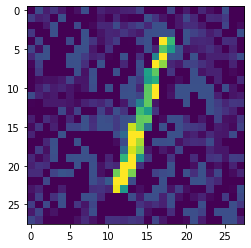

In [4]:
# orig 1, guide 5
plt.imshow(x_test_adv[2,...].squeeze())

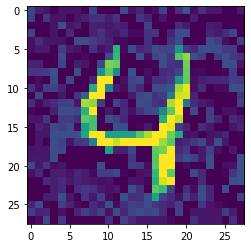

In [5]:
# orig 4, guide 9
plt.imshow(x_test_adv[4,...].squeeze())

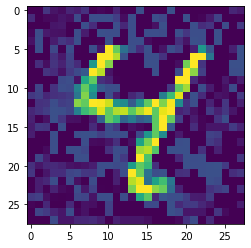

In [6]:
# orig 4, guide 2
plt.imshow(x_test_adv[6,...].squeeze())

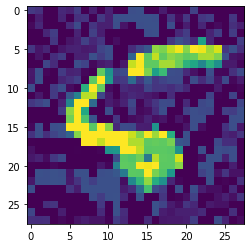

In [7]:
# orig 5, guide 9
plt.imshow(x_test_adv[8,...].squeeze())

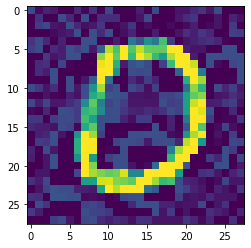

In [8]:
# orig 0, guide 8
plt.imshow(x_test_adv[10,...].squeeze())

In [9]:
# """
# The script demonstrates a simple example of using ART with PyTorch. The example train a small model on the MNIST dataset
# and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
# it would also be possible to provide a pretrained model to the ART classifier.
# The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
# """
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import numpy as np

# from art.attacks.evasion import FeatureAdversaries
# from art.estimators.classification import PyTorchClassifier
# from art.utils import load_mnist


# # Step 1: Load the MNIST dataset

# (x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# # Step 1a: Swap axes to PyTorch's NCHW format

# x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
# x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

# # Step 2: Create the model

# model = nn.Sequential(
#     nn.Conv2d(1, 4, 5), nn.ReLU(), nn.MaxPool2d(2, 2), 
#     nn.Conv2d(4, 10, 5), nn.ReLU(), nn.MaxPool2d(2, 2),

#     nn.Flatten(), 
#     nn.Linear(4*4*10, 100),    
#     nn.Linear(100, 10)
# )
# # Step 2a: Define the loss function and the optimizer

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)

# # Step 3: Create the ART classifier

# classifier = PyTorchClassifier(
#     model=model,
#     clip_values=(min_pixel_value, max_pixel_value),
#     loss=criterion,
#     optimizer=optimizer,
#     input_shape=(1, 28, 28),
#     nb_classes=10,
# )

# # Step 4: Train the ART classifier

# classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

# # Step 5: Evaluate the ART classifier on benign test examples

# predictions = classifier.predict(x_test)
# accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
# print("Accuracy on benign test examples: {}%".format(accuracy * 100))

# # Step 6: Generate adversarial test examples
# attack = FeatureAdversaries(classifier, layer=3, delta=10/255)

# valid = np.argmax(y_test, axis=1)[:100] != np.argmax(y_test, axis=1)[100:200]
# source = x_test[:100][valid][:32]
# guide = x_test[100:200][valid][:32]

# # note: choose maxiter=2000 (default, 20) according to paper code
# x_test_adv = attack.generate(source, guide, maxiter=2000).astype(np.float32)

# # Step 7: Evaluate the ART classifier on adversarial test examples

# predictions = classifier.predict(x_test_adv)
# accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:100][valid][:32], axis=1)) / len(y_test[:100][valid][:32])
# print("Accuracy on adversarial test batch: {}%".format(accuracy * 100))


In [10]:
# import matplotlib.pyplot as plt

# # orig 7, guide 6
# plt.imshow(x_test_adv[0,...].squeeze())

In [11]:
# # orig 1, guide 5
# plt.imshow(x_test_adv[2,...].squeeze())

In [12]:
# # orig 4, guide 9
# plt.imshow(x_test_adv[4,...].squeeze())

In [13]:
# # orig 4, guide 2
# plt.imshow(x_test_adv[6,...].squeeze())

In [14]:
# # orig 5, guide 9
# plt.imshow(x_test_adv[8,...].squeeze())

In [15]:
# # orig 0, guide 8
# plt.imshow(x_test_adv[10,...].squeeze())